In [1]:
from init import *

In [2]:
def BuildModel_Simple():
    '''Geometrical brownian motion with hidden drift and diffusion parameters.
    The measurements are zero coupon bonds.
    '''
    m = Model()
    m.TimeStart = 0
    m.TimeSteps = 1
    m.NumPaths = 1
    m.Add(IndependentGaussian())
    bm_a = m.Add(BrownianMotion(
        Parameter(value=0,step=0.1), # start
        Parameter(value=0,step=0.1), # drift
        2  # diffusion
    ))
    m.Add(CorrelatedGaussian(Parameter(value=-1,min=-1,max=1,step=0.0),bm_a.GetStateNumber(),bm_a.GetStateNumber()+1))
    bm_b = m.Add(BrownianMotion(0,0,Parameter(value=2,step=0.2))) # start, drift, diffusion
    assert (bm_a.GetStateNumber()+1) == bm_b.GetStateNumber()
    return m

In [3]:
import time
model = BuildModel_Simple()
model.NumPaths = 10000
model.TimeSteps = 100
model.RunTimeoutSeconds = 16.7
for t in [1,2,5,10]:
    model.evaluations.append(EvaluationPoint(0,t))
model.json()

'{"TimeStart": 0, "TimeSteps": 100, "NumPaths": 10000, "updaters": [{"name": "IndependentGaussian", "refs": []}, {"name": "BrownianMotion", "start": {"value": 0, "step": 0.1}, "args": [{"value": 0, "step": 0.1}, 2]}, {"name": "CorrelatedGaussian", "args": [{"value": -1, "step": 0.0, "min": -1, "max": 1}], "refs": [0, 1]}, {"name": "BrownianMotion", "start": 0, "args": [0, {"value": 2, "step": 0.2}]}], "evaluations": [{"state": 0, "time": 1, "histograms": []}, {"state": 0, "time": 2, "histograms": []}, {"state": 0, "time": 5, "histograms": []}, {"state": 0, "time": 10, "histograms": []}], "RandomSeed": -1, "RunTimeoutSeconds": 16.7, "MemoryLimitKB": 64}'

In [4]:
result = requests.post(f'{server}/model',model.json())
er = EvaluationResults(result.json(),model)
er.df()

,name,title,state,time,step,npaths,mean,mean_error,stddev,skewness
0,BrownianMotion,,0,1.0,10,10000,0.017661,0.020108,2.010824,-0.007322
1,BrownianMotion,,1,1.0,10,10000,-0.017661,0.020108,2.010824,0.007322
2,BrownianMotion,,0,2.0,20,10000,0.019449,0.028603,2.860298,-0.009940
3,BrownianMotion,,1,2.0,20,10000,-0.019449,0.028603,2.860298,0.009940
4,BrownianMotion,,0,5.0,50,10000,0.043380,0.044796,4.479594,-0.023689
5,BrownianMotion,,1,5.0,50,10000,-0.043380,0.044796,4.479594,0.023689
6,BrownianMotion,,0,10.0,100,10000,0.030664,0.063726,6.372644,-0.030801
7,BrownianMotion,,1,10.0,100,10000,-0.030664,0.063726,6.372644,0.030801


In [5]:
for u in model.updaters:
    print((u.GetEquationNumber(),u.GetStateNumber()),u.json())

(0, None) {"name": "IndependentGaussian", "refs": []}
(1, 0) {"name": "BrownianMotion", "start": {"value": 0, "step": 0.1}, "args": [{"value": 0, "step": 0.1}, 2]}
(2, None) {"name": "CorrelatedGaussian", "args": [{"value": -1, "step": 0.0, "min": -1, "max": 1}], "refs": [0, 1]}
(3, 1) {"name": "BrownianMotion", "start": 0, "args": [0, {"value": 2, "step": 0.2}]}


In [6]:
calib = ModelCalibration(model)
calib.Print()

3 calibration parameters:
BrownianMotion eq=1 narg=-1 {"value": 0, "step": 0.1}
BrownianMotion eq=1 narg=0 {"value": 0, "step": 0.1}
BrownianMotion eq=3 narg=1 {"value": 2, "step": 0.2}


In [7]:
for cpar in calib.cpars:
    print(cpar)

eq=1 narg=-1 {"value": 0, "step": 0.1}
eq=1 narg=0 {"value": 0, "step": 0.1}
eq=3 narg=1 {"value": 2, "step": 0.2}


In [8]:
ModelCalibration(model).GetState()

[0, 0, 2]

In [9]:
calib.SetCalibrationParameter(0,0.1)
print(calib.GetState())
calib.SetCalibrationParameter(0,0.11)
print(calib.GetState())
calib.SetCalibrationParameter(1,2.22)
print(calib.GetState())


[0.1, 0, 2]
[0.11, 0, 2]
[0.11, 2.22, 2]


In [10]:
model.json()

'{"TimeStart": 0, "TimeSteps": 100, "NumPaths": 10000, "updaters": [{"name": "IndependentGaussian", "refs": []}, {"name": "BrownianMotion", "start": {"value": 0.11, "step": 0.1}, "args": [{"value": 2.22, "step": 0.1}, 2]}, {"name": "CorrelatedGaussian", "args": [{"value": -1, "step": 0.0, "min": -1, "max": 1}], "refs": [0, 1]}, {"name": "BrownianMotion", "start": 0, "args": [0, {"value": 2, "step": 0.2}]}], "evaluations": [{"state": 0, "time": 1, "histograms": []}, {"state": 0, "time": 2, "histograms": []}, {"state": 0, "time": 5, "histograms": []}, {"state": 0, "time": 10, "histograms": []}], "RandomSeed": -1, "RunTimeoutSeconds": 16.7, "MemoryLimitKB": 64}'

# Using KalmanFilter

In [11]:
class ModelCalibUKF (ModelCalibration, UnscentedKalmanFilter):
    def __init__ (self):
        
        self.model = Model()
        self.model.TimeStart = 0
        self.model.TimeSteps = 100
        self.model.NumPaths = 10000
        self.model.Add( IndependentGaussian() )
        self.gbm = self.model.Add( BrownianMotion(
            start     = Parameter(value=0.1,step=0.1),
            drift     = Parameter(value=0.2,step=0.1),
            diffusion = Parameter(value=0.3,step=0.1)
        ))
        self.zcb = self.model.Add( ZeroCouponBond(
            underlying = self.gbm.GetStateNumber(),
            start      = 1,
        ))
        
        L = 3
        self.__true_state = np.matrix([
            [self.gbm.GetStart().value],
            [self.gbm.GetDrift().value],
            [self.gbm.GetDiffusion().value]
        ], dtype=np.float64)
        
        for t in [1,2,5,7]:
            self.model.evaluations.append(EvaluationPoint(0,t))
        
        self.result = EvaluationResults(
            requests.post(f'{server}/model',self.model.json()).json(),
            self.model
        )

        M = self.result.NumEvaluations()
        self.measurement = CreateMatrix (M,1)
        self.measurement_error = CreateMatrix (M,M)
        
        for i in range(self.result.NumEvaluations()):
            stat = self.result.GetStateEvaluationResult(self.zcb.GetStateNumber(),i)
            self.measurement[i,0] = stat.GetMean()
            self.measurement_error[i,i] = max(stat.GetMeanError(),0.01)
        print('Measurements:')
        print(self.measurement)
        print('Measurements error matrix:')
        print(self.measurement_error)
        
        ModelCalibration.__init__ (self, self.model)
        
        big_error = 0.1
        self.x = CreateMatrix(L,1)
        self.P = CreateMatrix(L,L)
        for i in range(L):
            self.x[i,0] = self.__true_state[i,0] - 0.0
            self.P[i,i] = big_error
        self.initial_state = self.x

        UnscentedKalmanFilter.__init__(self,L,M)
        
        self.monitor = KalmanFilterMonitor(self)

    def GetTrueState (self):
        '''optional, only useful for testing'''
        return self.__true_state

    def GetPredictedMeasurements (self, states, iteration):

        models_request = []
        
        for state in states:
            for i in range(self.L):
                self.SetCalibrationParameter(i,state[i,0])
            models_request.append(self.model.json())
        
        models_request_json = '[' + (','.join(models_request)) + ']'
        
        models_responeses = requests.post(f'{server}/models',models_request_json).json()
        
        predicted_measurements = []
        for response in models_responeses:
            result = EvaluationResults(response)
            assert result.NumEvaluations() == self.M
            
            predicted_measurement = CreateMatrix (self.M,1)
            for i in range(self.M):
                stat = result.GetStateEvaluationResult(self.zcb.GetStateNumber(),i)
                predicted_measurement[i,0] = stat.GetMean()
            predicted_measurements.append(predicted_measurement)

        return predicted_measurements

#     def GetPredictedMeasurement (self, state, iteration):
#         '''override'''

#         for i in range(self.L):
#             self.SetCalibrationParameter(i,state[i,0])
        
#         result = EvaluationResults(
#             requests.post(f'{server}/model',self.model.json()).json(),
#             self.model
#         )

#         predicted_measurement = CreateMatrix (self.M,1)
#         assert result.NumEvaluations() == self.M
#         for i in range(self.M):
#             stat = result.GetStateEvaluationResult(self.zcb.GetStateNumber(),i)
#             predicted_measurement[i,0] = stat.GetMean()
        
#         return predicted_measurement
        
    def GetMeasurement (self, iteration):
        '''override'''
        return (self.measurement, self.measurement_error)
    
    def Log (self, iteration, name, value):
        if 0:
            print(f'iteration={iteration} {name}')
            if hasattr(value,'__iter__'):
                for v in value:
                    print(v)
            else:
                print(value)
        self.monitor.AddData(iteration, name, value)

In [12]:
ckf = ModelCalibUKF()
t_start = time.time()
ckf.RunAllIterations(0,100)
t_end = time.time()
print(f'Execution time was {t_end-t_start} seconds')

Measurements:
[[0.82964885]
 [0.60397768]
 [0.31767154]
 [0.54855061]]
Measurements error matrix:
[[0.01       0.         0.         0.        ]
 [0.         0.01       0.         0.        ]
 [0.         0.         0.01569873 0.        ]
 [0.         0.         0.         0.19270737]]
Execution time was 12.439345598220825 seconds


In [13]:
print('True state:')
print(ckf.GetTrueState())

print('Initial (guess) state:')
print(ckf.initial_state)

print('Computed state:')
print(ckf.x)

True state:
[[0.1]
 [0.2]
 [0.3]]
Initial (guess) state:
[[0.1]
 [0.2]
 [0.3]]
Computed state:
[[0.14880795]
 [0.16527166]
 [0.2819639 ]]


In [14]:
import pandas as pd
df = pd.DataFrame(ckf.monitor._data)
df

,iteration,residual[0],residual[1],residual[2],residual[3],residual.length,state[0],state[1],state[2],state_diff[0],state_diff[1],state_diff[2],state_diff.length
0,0,3.097474,2.584703,17.280316,3042.589067,3042.640813,0.072307,0.268837,0.221380,-0.027693,0.068837,-0.078620,0.108105
1,1,2.997798,1.868112,0.109581,-0.339343,3.550183,0.095594,0.223577,0.303166,-0.004406,0.023577,0.003166,0.024193
2,2,3.025348,2.153883,2.395509,444.597904,444.619867,0.096418,0.201640,0.276949,-0.003582,0.001640,-0.023051,0.023385
3,3,3.049725,2.191152,0.845132,0.811394,3.933774,0.120523,0.190049,0.288527,0.020523,-0.009951,-0.011473,0.025531
4,4,2.979538,2.136570,1.037520,1.504394,4.096611,0.119326,0.193055,0.293586,0.019326,-0.006945,-0.006414,0.021514
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,2.908979,2.084060,1.125077,4.507551,5.864237,0.148807,0.165240,0.281894,0.048807,-0.034760,-0.018106,0.062596
97,97,2.917442,2.104733,1.128151,1.971914,4.254708,0.148811,0.165234,0.281900,0.048811,-0.034766,-0.018100,0.062600
98,98,2.915039,2.090967,1.055700,1.383451,3.987234,0.148717,0.165313,0.281961,0.048717,-0.034687,-0.018039,0.062465
99,99,2.912302,2.088707,1.062627,1.601124,4.066568,0.148752,0.165305,0.281964,0.048752,-0.034695,-0.018036,0.062496


<AxesSubplot: xlabel='iteration'>

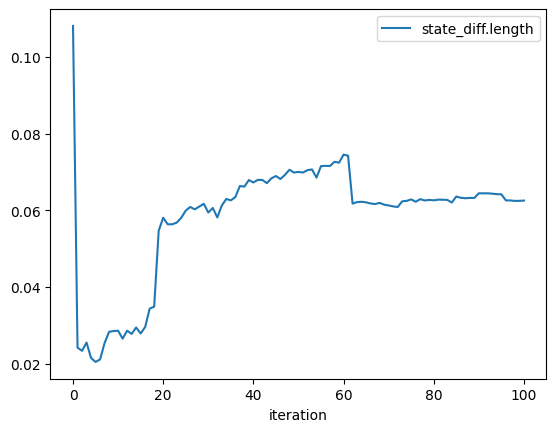

In [15]:
df.plot(x='iteration', y='state_diff.length')

<AxesSubplot: xlabel='iteration'>

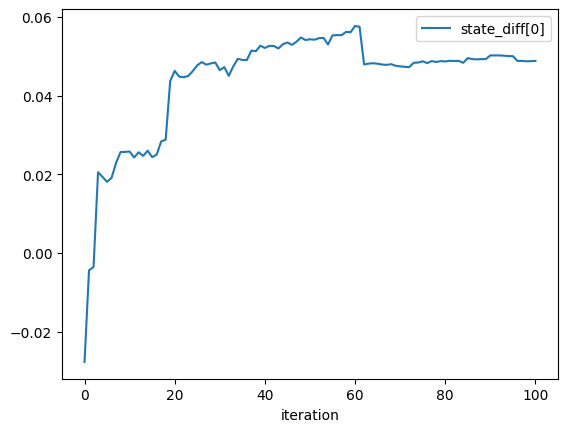

In [16]:
df.plot(x='iteration', y='state_diff[0]')

<AxesSubplot: xlabel='iteration'>

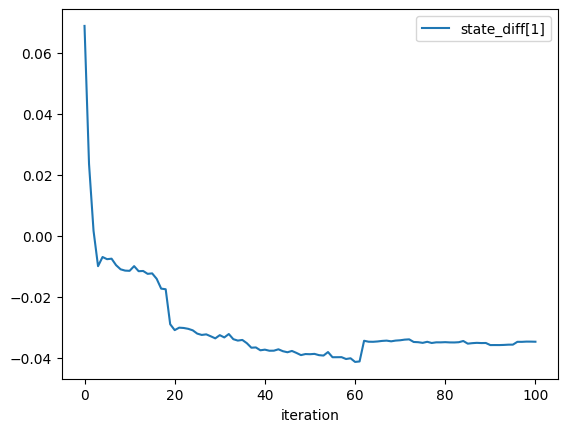

In [17]:
df.plot(x='iteration', y='state_diff[1]')

<AxesSubplot: xlabel='iteration'>

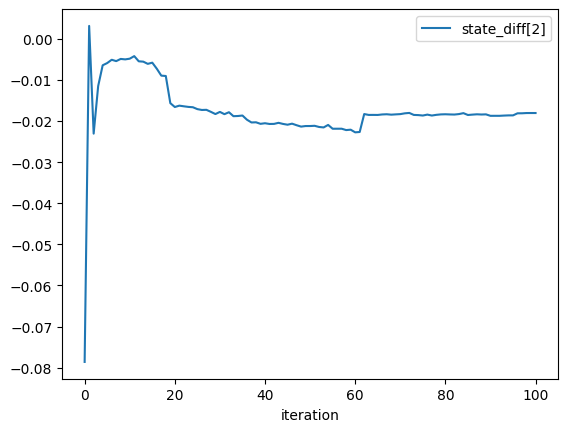

In [18]:
df.plot(x='iteration', y='state_diff[2]')

<AxesSubplot: xlabel='iteration'>

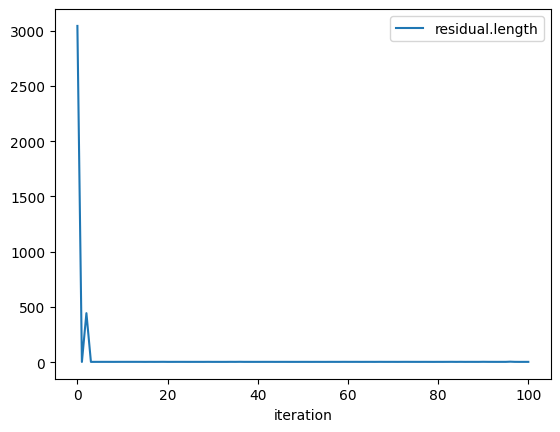

In [19]:
df.plot(x='iteration', y='residual.length')

<AxesSubplot: xlabel='iteration'>

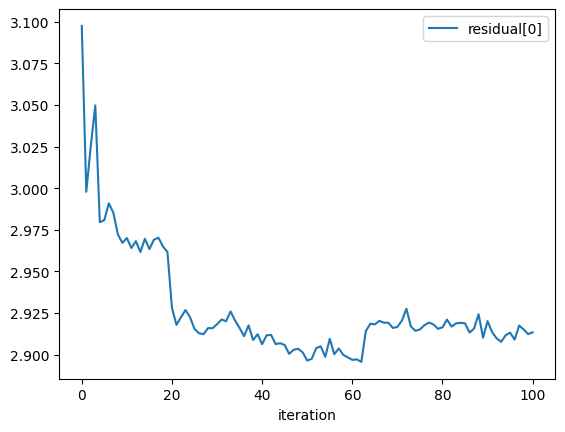

In [20]:
df.plot(x='iteration', y='residual[0]')

<AxesSubplot: xlabel='iteration'>

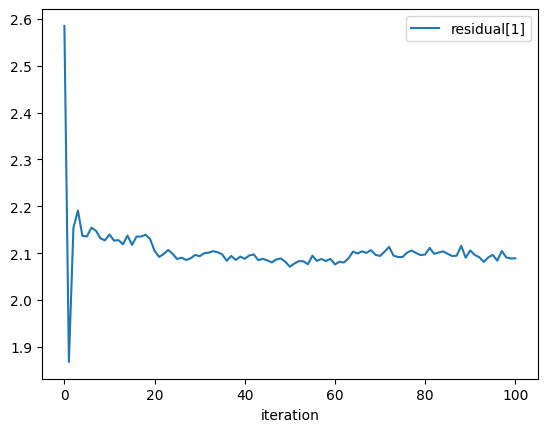

In [21]:
df.plot(x='iteration', y='residual[1]')

<AxesSubplot: xlabel='iteration'>

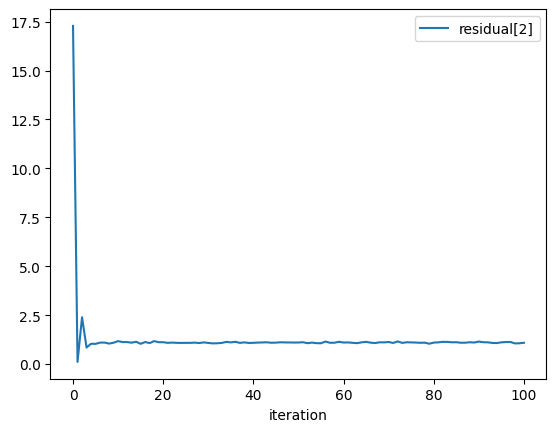

In [22]:
df.plot(x='iteration', y='residual[2]')

<AxesSubplot: xlabel='iteration'>

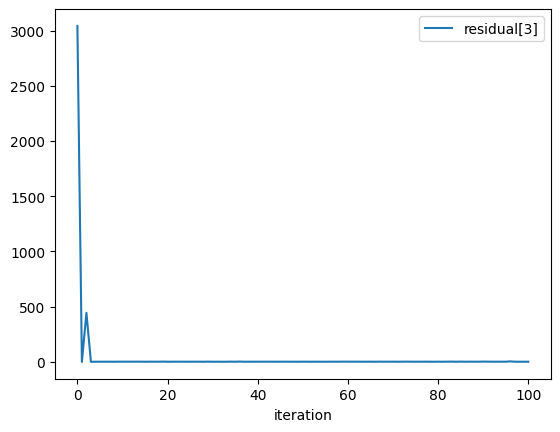

In [23]:
df.plot(x='iteration', y='residual[3]')

In [24]:
# dfs = df.loc[df['iteration'] > 3]
# dfs.plot(x='iteration', y='residual[3]')